In [1]:
# Change to project root
import os
os.chdir('..')

In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
parallel_calls = 8
max_trans = 3
stddev = 0.1

# Load the data

In [5]:
from transforming_autoencoders import mnist, data
mnist_data = mnist.MNIST('data')

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [6]:
def train_input_fn(batch_size):
    return mnist_data.train_input_fn()(batch_size,
                                       lambda: data.affine_fn(batch_size, stddev, max_trans),
                                       parallel_calls)
def eval_input_fn(batch_size):
    return mnist_data.eval_input_fn()(batch_size,
                                      lambda: data.affine_fn(batch_size, stddev, max_trans),
                                      parallel_calls)

# Create the estimator

In [7]:
from transforming_autoencoders import trans_autoencoder_estimator
model = trans_autoencoder_estimator.create_transforming_autoencoder(model_dir='model/affine',
                                                                    num_capsules=30,
                                                                    num_rec=50,
                                                                    num_gen=50,
                                                                    trans_size=8,
                                                                    trans_fn='affine')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/affine', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd68cfe7c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train the model

In [8]:
batch_size = 64
epochs = 100
steps = int(mnist_data.train_size() * epochs / batch_size)
model.train(input_fn=lambda:train_input_fn(batch_size), steps=steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into model/affine/model.ckpt.
INFO:tensorflow:loss = 0.3557053, step = 1
INFO:tensorflow:global_step/sec: 29.5946
INFO:tensorflow:loss = 0.08589542, step = 101 (3.380 sec)
INFO:tensorflow:global_step/sec: 50.6538
INFO:tensorflow:loss = 0.07336524, step = 201 (1.982 sec)
INFO:tensorflow:global_step/sec: 45.0694
INFO:tensorflow:loss = 0.07291857, step = 301 (2.210 sec)
INFO:tensorflow:global_step/sec: 47.8337
INFO:tensorflow:loss = 0.073521174, step = 401 (2.092 sec)
INFO:tensorflow:global_step/sec: 48.0051
INFO:tensorflow:loss = 0.06748138, step = 501 (2.082 sec)
INFO:tensorflow:global_step/sec: 51.496
INFO:tensorflow:loss = 0.06780286, step = 601 (1.942 sec)
INFO:tensorflow:global_step/sec: 53.0038
INFO:tensorflo

INFO:tensorflow:loss = 0.04624896, step = 7901 (1.901 sec)
INFO:tensorflow:global_step/sec: 54.0155
INFO:tensorflow:loss = 0.046843607, step = 8001 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.6678
INFO:tensorflow:loss = 0.051685635, step = 8101 (1.862 sec)
INFO:tensorflow:global_step/sec: 54.1567
INFO:tensorflow:loss = 0.044087905, step = 8201 (1.846 sec)
INFO:tensorflow:global_step/sec: 53.5908
INFO:tensorflow:loss = 0.050865427, step = 8301 (1.866 sec)
INFO:tensorflow:global_step/sec: 53.929
INFO:tensorflow:loss = 0.048374105, step = 8401 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.5294
INFO:tensorflow:loss = 0.047560867, step = 8501 (1.868 sec)
INFO:tensorflow:global_step/sec: 53.8417
INFO:tensorflow:loss = 0.04693114, step = 8601 (1.858 sec)
INFO:tensorflow:global_step/sec: 52.8643
INFO:tensorflow:loss = 0.04681802, step = 8701 (1.891 sec)
INFO:tensorflow:global_step/sec: 53.2171
INFO:tensorflow:loss = 0.048255716, step = 8801 (1.879 sec)
INFO:tensorflow:global_step/sec: 53

INFO:tensorflow:loss = 0.039434366, step = 16001 (1.863 sec)
INFO:tensorflow:global_step/sec: 53.7501
INFO:tensorflow:loss = 0.038978416, step = 16101 (1.860 sec)
INFO:tensorflow:global_step/sec: 54.0041
INFO:tensorflow:loss = 0.041531693, step = 16201 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.9686
INFO:tensorflow:loss = 0.039304074, step = 16301 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.9878
INFO:tensorflow:loss = 0.039056893, step = 16401 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.0127
INFO:tensorflow:loss = 0.038845416, step = 16501 (1.852 sec)
INFO:tensorflow:global_step/sec: 54.0346
INFO:tensorflow:loss = 0.035860386, step = 16601 (1.850 sec)
INFO:tensorflow:global_step/sec: 53.8644
INFO:tensorflow:loss = 0.03894221, step = 16701 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.0824
INFO:tensorflow:loss = 0.039717093, step = 16801 (1.884 sec)
INFO:tensorflow:global_step/sec: 54.0632
INFO:tensorflow:loss = 0.038208917, step = 16901 (1.850 sec)
INFO:tensorflow:global

INFO:tensorflow:loss = 0.033664096, step = 24101 (1.851 sec)
INFO:tensorflow:global_step/sec: 53.3937
INFO:tensorflow:loss = 0.03517017, step = 24201 (1.873 sec)
INFO:tensorflow:global_step/sec: 53.8392
INFO:tensorflow:loss = 0.03355914, step = 24301 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.3364
INFO:tensorflow:loss = 0.033657297, step = 24401 (1.875 sec)
INFO:tensorflow:global_step/sec: 53.6457
INFO:tensorflow:loss = 0.03313869, step = 24501 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.8527
INFO:tensorflow:loss = 0.033692833, step = 24601 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.7727
INFO:tensorflow:loss = 0.036297485, step = 24701 (1.859 sec)
INFO:tensorflow:global_step/sec: 53.6722
INFO:tensorflow:loss = 0.03374268, step = 24801 (1.863 sec)
INFO:tensorflow:global_step/sec: 53.7177
INFO:tensorflow:loss = 0.034423593, step = 24901 (1.862 sec)
INFO:tensorflow:global_step/sec: 53.0127
INFO:tensorflow:loss = 0.034778703, step = 25001 (1.886 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 50.7536
INFO:tensorflow:loss = 0.03292693, step = 32201 (1.970 sec)
INFO:tensorflow:global_step/sec: 53.809
INFO:tensorflow:loss = 0.031425793, step = 32301 (1.859 sec)
INFO:tensorflow:global_step/sec: 54.0992
INFO:tensorflow:loss = 0.030241897, step = 32401 (1.848 sec)
INFO:tensorflow:global_step/sec: 53.6254
INFO:tensorflow:loss = 0.03220756, step = 32501 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.937
INFO:tensorflow:loss = 0.03193668, step = 32601 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.5688
INFO:tensorflow:loss = 0.032466903, step = 32701 (1.868 sec)
INFO:tensorflow:global_step/sec: 53.4889
INFO:tensorflow:loss = 0.03390981, step = 32801 (1.868 sec)
INFO:tensorflow:global_step/sec: 53.7423
INFO:tensorflow:loss = 0.031455666, step = 32901 (1.861 sec)
INFO:tensorflow:global_step/sec: 53.5147
INFO:tensorflow:loss = 0.029935887, step = 33001 (1.869 sec)
INFO:tensorflow:global_step/sec: 53.8722
INFO:tensorflow:loss = 0.03508553, step = 33101

INFO:tensorflow:global_step/sec: 53.7768
INFO:tensorflow:loss = 0.029014952, step = 40301 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.8875
INFO:tensorflow:loss = 0.030617096, step = 40401 (1.855 sec)
INFO:tensorflow:global_step/sec: 53.9879
INFO:tensorflow:loss = 0.030711725, step = 40501 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.5766
INFO:tensorflow:loss = 0.029936118, step = 40601 (1.867 sec)
INFO:tensorflow:global_step/sec: 53.1926
INFO:tensorflow:loss = 0.03165194, step = 40701 (1.880 sec)
INFO:tensorflow:global_step/sec: 53.6085
INFO:tensorflow:loss = 0.03085374, step = 40801 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.7823
INFO:tensorflow:loss = 0.029597292, step = 40901 (1.859 sec)
INFO:tensorflow:global_step/sec: 53.5699
INFO:tensorflow:loss = 0.029931039, step = 41001 (1.867 sec)
INFO:tensorflow:global_step/sec: 53.4159
INFO:tensorflow:loss = 0.030752297, step = 41101 (1.872 sec)
INFO:tensorflow:global_step/sec: 53.5373
INFO:tensorflow:loss = 0.032029063, step = 

INFO:tensorflow:global_step/sec: 53.6784
INFO:tensorflow:loss = 0.030168297, step = 48401 (1.864 sec)
INFO:tensorflow:global_step/sec: 53.4578
INFO:tensorflow:loss = 0.031592865, step = 48501 (1.869 sec)
INFO:tensorflow:global_step/sec: 53.831
INFO:tensorflow:loss = 0.028016329, step = 48601 (1.859 sec)
INFO:tensorflow:global_step/sec: 53.479
INFO:tensorflow:loss = 0.031392585, step = 48701 (1.869 sec)
INFO:tensorflow:global_step/sec: 53.3274
INFO:tensorflow:loss = 0.030118925, step = 48801 (1.875 sec)
INFO:tensorflow:global_step/sec: 52.9934
INFO:tensorflow:loss = 0.028876323, step = 48901 (1.887 sec)
INFO:tensorflow:global_step/sec: 53.8684
INFO:tensorflow:loss = 0.031920895, step = 49001 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.7049
INFO:tensorflow:loss = 0.03176329, step = 49101 (1.862 sec)
INFO:tensorflow:global_step/sec: 53.561
INFO:tensorflow:loss = 0.028195526, step = 49201 (1.867 sec)
INFO:tensorflow:global_step/sec: 53.7529
INFO:tensorflow:loss = 0.028514657, step = 49

INFO:tensorflow:global_step/sec: 53.1694
INFO:tensorflow:loss = 0.027957117, step = 56501 (1.881 sec)
INFO:tensorflow:global_step/sec: 53.6008
INFO:tensorflow:loss = 0.026628187, step = 56601 (1.866 sec)
INFO:tensorflow:global_step/sec: 53.6422
INFO:tensorflow:loss = 0.030951431, step = 56701 (1.864 sec)
INFO:tensorflow:global_step/sec: 54.045
INFO:tensorflow:loss = 0.02899111, step = 56801 (1.851 sec)
INFO:tensorflow:global_step/sec: 53.4676
INFO:tensorflow:loss = 0.029823218, step = 56901 (1.870 sec)
INFO:tensorflow:global_step/sec: 53.6693
INFO:tensorflow:loss = 0.030407812, step = 57001 (1.863 sec)
INFO:tensorflow:global_step/sec: 53.4098
INFO:tensorflow:loss = 0.026305988, step = 57101 (1.873 sec)
INFO:tensorflow:global_step/sec: 53.7411
INFO:tensorflow:loss = 0.02596174, step = 57201 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.5297
INFO:tensorflow:loss = 0.027063875, step = 57301 (1.868 sec)
INFO:tensorflow:global_step/sec: 54.0775
INFO:tensorflow:loss = 0.031478047, step = 5

INFO:tensorflow:global_step/sec: 53.4444
INFO:tensorflow:loss = 0.026530119, step = 64501 (1.873 sec)
INFO:tensorflow:global_step/sec: 50.5293
INFO:tensorflow:loss = 0.029406026, step = 64601 (1.977 sec)
INFO:tensorflow:global_step/sec: 53.9298
INFO:tensorflow:loss = 0.028136631, step = 64701 (1.854 sec)
INFO:tensorflow:global_step/sec: 53.91
INFO:tensorflow:loss = 0.027352002, step = 64801 (1.855 sec)
INFO:tensorflow:global_step/sec: 53.5072
INFO:tensorflow:loss = 0.028813645, step = 64901 (1.869 sec)
INFO:tensorflow:global_step/sec: 54.1835
INFO:tensorflow:loss = 0.028511822, step = 65001 (1.846 sec)
INFO:tensorflow:global_step/sec: 53.6665
INFO:tensorflow:loss = 0.028726969, step = 65101 (1.864 sec)
INFO:tensorflow:global_step/sec: 54.007
INFO:tensorflow:loss = 0.028924052, step = 65201 (1.850 sec)
INFO:tensorflow:global_step/sec: 53.9898
INFO:tensorflow:loss = 0.026489768, step = 65301 (1.852 sec)
INFO:tensorflow:global_step/sec: 53.5426
INFO:tensorflow:loss = 0.026109546, step = 6

INFO:tensorflow:global_step/sec: 53.6032
INFO:tensorflow:loss = 0.02880237, step = 72601 (1.865 sec)
INFO:tensorflow:global_step/sec: 53.782
INFO:tensorflow:loss = 0.026177334, step = 72701 (1.860 sec)
INFO:tensorflow:global_step/sec: 54.0807
INFO:tensorflow:loss = 0.028730894, step = 72801 (1.849 sec)
INFO:tensorflow:global_step/sec: 53.8387
INFO:tensorflow:loss = 0.026812227, step = 72901 (1.857 sec)
INFO:tensorflow:global_step/sec: 53.4881
INFO:tensorflow:loss = 0.02675718, step = 73001 (1.870 sec)
INFO:tensorflow:global_step/sec: 53.8124
INFO:tensorflow:loss = 0.028221766, step = 73101 (1.858 sec)
INFO:tensorflow:global_step/sec: 53.1644
INFO:tensorflow:loss = 0.027894609, step = 73201 (1.881 sec)
INFO:tensorflow:global_step/sec: 53.487
INFO:tensorflow:loss = 0.02912857, step = 73301 (1.870 sec)
INFO:tensorflow:global_step/sec: 54.2061
INFO:tensorflow:loss = 0.028699676, step = 73401 (1.845 sec)
INFO:tensorflow:global_step/sec: 53.0746
INFO:tensorflow:loss = 0.028464563, step = 735

INFO:tensorflow:global_step/sec: 54.6705
INFO:tensorflow:loss = 0.026538212, step = 80701 (1.829 sec)
INFO:tensorflow:global_step/sec: 54.1158
INFO:tensorflow:loss = 0.027245818, step = 80801 (1.848 sec)
INFO:tensorflow:global_step/sec: 57.9928
INFO:tensorflow:loss = 0.02691702, step = 80901 (1.724 sec)
INFO:tensorflow:global_step/sec: 58.6123
INFO:tensorflow:loss = 0.027814033, step = 81001 (1.706 sec)
INFO:tensorflow:global_step/sec: 58.1171
INFO:tensorflow:loss = 0.026530148, step = 81101 (1.721 sec)
INFO:tensorflow:global_step/sec: 58.2368
INFO:tensorflow:loss = 0.028645754, step = 81201 (1.717 sec)
INFO:tensorflow:global_step/sec: 55.653
INFO:tensorflow:loss = 0.027297921, step = 81301 (1.797 sec)
INFO:tensorflow:global_step/sec: 58.0193
INFO:tensorflow:loss = 0.026423113, step = 81401 (1.724 sec)
INFO:tensorflow:global_step/sec: 58.1905
INFO:tensorflow:loss = 0.024689086, step = 81501 (1.718 sec)
INFO:tensorflow:global_step/sec: 57.5028
INFO:tensorflow:loss = 0.026796838, step = 

# Evaluate the model

In [9]:
test_data = eval_input_fn(4)
with tf.Session() as sess:
    img, trans, expec = sess.run([test_data[0]['image'],
                                 test_data[0]['transformation'],
                                 test_data[1]])

In [10]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": img, "transformation": trans},
    num_epochs=1,
    shuffle=False)
yhat = list(model.predict(input_fn=predict_input_fn))
pred = np.array(list(map(lambda x: x['out_image'], yhat)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/affine/model.ckpt-85937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


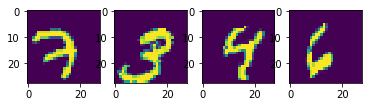

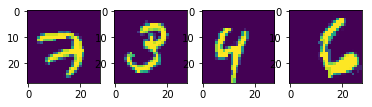

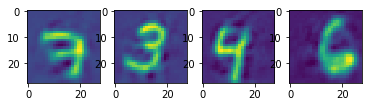

[[ 0.89268446  0.08635383 -2.5963433  -0.02895888  1.0838392  -0.8631099
   0.          0.        ]
 [ 1.1946622  -0.22446644  0.6075059  -0.0776542   1.1145201   3.180896
   0.          0.        ]
 [ 1.1523021  -0.10161692  3.9793234  -0.01061558  0.86414117  1.2622582
   0.          0.        ]
 [ 0.71864927 -0.14069697 -0.13265586 -0.1009462   0.85266227  4.8086886
   0.          0.        ]]


In [12]:
from transforming_autoencoders import plot
plot.plot_some(img)
plot.plot_some(expec)
plot.plot_some(pred)
print(trans)